In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU # relu varyansyonudur. girdi +x ilse çıktı=+x girdi -x ise çıktı -ax olur (a = çok çok küçük bir sayı)
from tensorflow.keras.layers import Dense, Flatten,Reshape,Conv2D,Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization


from tqdm import tqdm # for döngüsüne sayaç eklemek için

In [ ]:
# mnist veri setini yükleme
(x_train,_),(_,_) = mnist.load_data() # sadece training yükle


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# normalizasyon
x_train = x_train/255.0

In [ ]:
# boyut ayarlaması (28x28) -> (28,28,1)
x_train = np.expand_dims(x_train,axis=-1)

In [ ]:
# gan parametreleri
z_dim = 100 # gürültü vektörünün boyutu

In [ ]:
# discriminator modeline tanımla
def build_discriminator():
    model = Sequential()

    # Conv2D: 64 filtre, 3x3 cekirdek(kernel), stride =2 # kaç pixel atlayacağı işlem sırasında,padding=same,activation=LeakyReLU
    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same',input_shape=(28,28,1)))
    model.add(LeakyReLU(alpha=0.2))
    # Conv2D: 128 filtre, 3x3 cekirdek(kernel), stride =2 # kaç pixel atlayacağı işlem sırasında,padding=same,activation=LeakyReLU
    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # flatten -> output layer
    model.add(Flatten()) # görüntüyü tek boyutlu vektöre dönuştürür
    model.add(Dense(1,activation='sigmoid')) # output layer

    #compile
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(0.0002,0.5),metrics=['accuracy'])

    return model

In [ ]:
# generator modelini tenımla
def build_generator():
  model = Sequential()

  model.add(Dense(7*7*128,input_dim=z_dim)) # gürültü vektörlerinden yüksek boyutlu uzaya dönüşüm
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7,7,128))) # çıkışı (7x7x128) olacak şekilde ayarlıyoruz
  model.add(Conv2DTranspose(64,kernel_size=3,strides=2,padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  model.add(Conv2DTranspose(1,kernel_size=3,strides=2,padding='same',activation='tanh'))

  return model


In [22]:
# gan modeli oluşturma
def build_gan(generator,discriminator):

  discriminator.trainable = False #discriminator eğitilemez

  model = Sequential()
  model.add(generator) # gan yapısına ilk olarak generator ekliyoruz
  model.add(discriminator) # gan yapısına discriminator ekliyoruz
  model.compile(loss='binary_crossentropy',optimizer=Adam(0.0002,0.5))

  return model

In [23]:
discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator,discriminator)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
print(gan.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)            │ (None, 28, 28, 1)           │         708,097 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_6 (Sequential)            │ (None, 1)                   │          80,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 788,866 (3.01 MB)

 Trainable params: 707,969 (2.70 MB)

 Non-trainable params: 80,897 (316.00 KB)

None


In [25]:
# Train GAN
epochs = 1000
batch_size = 512
half_batch = batch_size // 2

# eğitim döngüsü
for epoch in tqdm(range(epochs),desc = "Traininig Process"): # tqdm ile ilerleme cubuğu eklenir
  # gerçek veriler ile discriminator eğirimi yapılacak
  idx = np.random.randint(0,x_train.shape[0],half_batch) #x_train içerisindeki rastgele 256 tane veriyi alıyor
  real_images = x_train[idx] # gerçek görüntüler
  real_labels = np.ones((half_batch,1)) # gerçek etiketler -1

  #fake verileri (generator'un ürettiği) ile discriminator eğitimi
  noise = np.random.normal(0,1,(half_batch,z_dim)) # gürültü vektörleri
  fake_images = generator.predict(noise) # generator'un ürettiği görüntüler
  fake_labels = np.zeros((half_batch,1)) # fake etiketler - 0


  # update discriminator
  d_loss_real = discriminator.train_on_batch(real_images,real_labels)# gerçek verilerle kayıp hesaplama
  d_loss_fake = discriminator.train_on_batch(fake_images,fake_labels)# sahte verilerle kayıp hesaplama
  d_loss = 0.5 * np.add(d_loss_real,d_loss_fake) # ortalama kaybı

  # Train GAN
  noise = np.random.normal(0,1,(batch_size,z_dim)) # gürültü vektörleri
  valid_y = np.ones((batch_size,1)) #doğru etiketler
  g_loss = gan.train_on_batch(noise,valid_y) # gan'ın içinde bulunan generator train

  if epoch % 100 == 0:
    print(f"\n{epoch}/{epochs} d_loss: {d_loss[0]} g_loss: {g_loss}")

Traininig Process:   0%|          | 0/1000 [00:00<?, ?it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
Traininig Process:   0%|          | 1/1000 [00:03<58:44,  3.53s/it]


0/1000 d_loss: 0.7059305906295776 g_loss: 0.7219572067260742
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   0%|          | 2/1000 [00:03<25:29,  1.53s/it]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   0%|          | 3/1000 [00:03<14:50,  1.12it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   0%|          | 4/1000 [00:03<09:51,  1.68it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   0%|          | 5/1000 [00:04<06:54,  2.40it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:   1%|          | 6/1000 [00:04<05:28,  3.03it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:   1%|          | 7/1000 [00:04<04:25,  3.73it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:   1%|          | 8/1000 [00:04<03:41,  4.48it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:   1%|          | 9/1000 [00:04<03:20,  4.95it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:   1%|          | 10/1000 [00:04<02:59,  5.52it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:   1%|          | 11/1000 [00:04<02:44,  6.00it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:   1%|          | 12/1000 [00:05<02:38,  6.24it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:   1%|▏         | 13/1000 [00:05<02:30,  6.56it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:   1%|▏         | 14/1000 [00:05<02:22,  6.90it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:   2%|▏         | 15/1000 [00:05<02:26,  6.74it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:   2%|▏         | 16/1000 [00:05<02:22,  6.92it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:   2%|▏         | 17/1000 [00:05<02:23,  6.84it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:   2%|▏         | 18/1000 [00:05<02:27,  6.64it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:   2%|▏         | 19/1000 [00:06<02:32,  6.45it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   2%|▏         | 20/1000 [00:06<02:18,  7.07it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   2%|▏         | 21/1000 [00:06<02:16,  7.18it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   2%|▏         | 22/1000 [00:06<02:06,  7.71it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   2%|▏         | 23/1000 [00:06<02:07,  7.66it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   2%|▏         | 24/1000 [00:06<02:07,  7.65it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   2%|▎         | 25/1000 [00:06<01:59,  8.16it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   3%|▎         | 26/1000 [00:06<01:53,  8.59it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   3%|▎         | 27/1000 [00:07<01:59,  8.16it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   3%|▎         | 28/1000 [00:07<02:01,  7.98it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   3%|▎         | 29/1000 [00:07<01:54,  8.47it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   3%|▎         | 30/1000 [00:07<01:58,  8.19it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   3%|▎         | 31/1000 [00:07<01:52,  8.62it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   3%|▎         | 32/1000 [00:07<01:47,  8.97it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:   3%|▎         | 33/1000 [00:07<01:47,  9.02it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   3%|▎         | 34/1000 [00:07<01:44,  9.22it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   4%|▎         | 35/1000 [00:07<01:43,  9.37it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   4%|▎         | 36/1000 [00:08<01:45,  9.14it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   4%|▎         | 37/1000 [00:08<01:44,  9.23it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   4%|▍         | 38/1000 [00:08<01:50,  8.73it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   4%|▍         | 39/1000 [00:08<01:54,  8.37it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   4%|▍         | 40/1000 [00:08<01:57,  8.14it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   4%|▍         | 41/1000 [00:08<01:51,  8.58it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   4%|▍         | 42/1000 [00:08<01:48,  8.86it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   4%|▍         | 43/1000 [00:08<01:45,  9.04it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:   4%|▍         | 44/1000 [00:08<01:44,  9.16it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   4%|▍         | 45/1000 [00:09<01:51,  8.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   5%|▍         | 46/1000 [00:09<01:48,  8.80it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   5%|▍         | 47/1000 [00:09<01:52,  8.47it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:   5%|▍         | 48/1000 [00:09<01:48,  8.75it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   5%|▍         | 49/1000 [00:09<01:54,  8.32it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   5%|▌         | 50/1000 [00:09<01:57,  8.06it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   5%|▌         | 51/1000 [00:09<01:59,  7.93it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   5%|▌         | 52/1000 [00:09<02:01,  7.79it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   5%|▌         | 53/1000 [00:10<01:54,  8.26it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   5%|▌         | 54/1000 [00:10<01:58,  7.99it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   6%|▌         | 55/1000 [00:10<02:00,  7.86it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   6%|▌         | 56/1000 [00:10<01:53,  8.29it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   6%|▌         | 57/1000 [00:10<01:50,  8.57it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   6%|▌         | 58/1000 [00:10<01:54,  8.23it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   6%|▌         | 59/1000 [00:10<01:56,  8.04it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   6%|▌         | 60/1000 [00:10<01:51,  8.45it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   6%|▌         | 61/1000 [00:11<01:48,  8.62it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:   6%|▌         | 62/1000 [00:11<01:48,  8.67it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   6%|▋         | 63/1000 [00:11<01:52,  8.32it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   6%|▋         | 64/1000 [00:11<01:48,  8.66it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   6%|▋         | 65/1000 [00:11<01:45,  8.90it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   7%|▋         | 66/1000 [00:11<01:42,  9.15it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   7%|▋         | 67/1000 [00:11<01:41,  9.23it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   7%|▋         | 68/1000 [00:11<01:38,  9.43it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   7%|▋         | 69/1000 [00:11<01:38,  9.43it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:   7%|▋         | 70/1000 [00:11<01:41,  9.13it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   7%|▋         | 71/1000 [00:12<01:48,  8.58it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   7%|▋         | 72/1000 [00:12<01:52,  8.26it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   7%|▋         | 73/1000 [00:12<01:48,  8.57it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   7%|▋         | 74/1000 [00:12<01:44,  8.84it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   8%|▊         | 75/1000 [00:12<01:49,  8.47it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:   8%|▊         | 76/1000 [00:12<01:52,  8.19it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   8%|▊         | 77/1000 [00:12<01:47,  8.59it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:   8%|▊         | 78/1000 [00:12<01:44,  8.79it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   8%|▊         | 79/1000 [00:13<01:42,  8.95it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:   8%|▊         | 80/1000 [00:13<01:48,  8.46it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   8%|▊         | 81/1000 [00:13<01:53,  8.10it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   8%|▊         | 82/1000 [00:13<01:48,  8.42it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   8%|▊         | 83/1000 [00:13<01:45,  8.71it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   8%|▊         | 84/1000 [00:13<01:49,  8.35it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:   8%|▊         | 85/1000 [00:13<01:46,  8.58it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   9%|▊         | 86/1000 [00:13<01:43,  8.82it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   9%|▊         | 87/1000 [00:13<01:42,  8.88it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   9%|▉         | 88/1000 [00:14<01:40,  9.11it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   9%|▉         | 89/1000 [00:14<01:41,  9.00it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   9%|▉         | 90/1000 [00:14<01:38,  9.22it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:   9%|▉         | 91/1000 [00:14<01:46,  8.51it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   9%|▉         | 92/1000 [00:14<01:50,  8.23it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:   9%|▉         | 93/1000 [00:14<01:53,  8.00it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:   9%|▉         | 94/1000 [00:14<01:48,  8.35it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  10%|▉         | 95/1000 [00:14<01:52,  8.05it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  10%|▉         | 96/1000 [00:15<01:54,  7.92it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  10%|▉         | 97/1000 [00:15<01:56,  7.76it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  10%|▉         | 98/1000 [00:15<01:50,  8.20it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  10%|▉         | 99/1000 [00:15<01:45,  8.57it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  10%|█         | 100/1000 [00:15<01:48,  8.27it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  10%|█         | 101/1000 [00:15<01:44,  8.62it/s]


100/1000 d_loss: 0.7270100116729736 g_loss: 0.430378794670105
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  10%|█         | 102/1000 [00:15<01:41,  8.84it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  10%|█         | 103/1000 [00:15<01:38,  9.10it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  10%|█         | 104/1000 [00:16<01:46,  8.40it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  10%|█         | 105/1000 [00:16<01:51,  8.01it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  11%|█         | 106/1000 [00:16<01:58,  7.52it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  11%|█         | 107/1000 [00:16<02:06,  7.08it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  11%|█         | 108/1000 [00:16<02:08,  6.97it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  11%|█         | 109/1000 [00:16<02:10,  6.83it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  11%|█         | 110/1000 [00:16<02:12,  6.73it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  11%|█         | 111/1000 [00:17<02:14,  6.62it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  11%|█         | 112/1000 [00:17<02:13,  6.66it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  11%|█▏        | 113/1000 [00:17<02:14,  6.58it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  11%|█▏        | 114/1000 [00:17<02:15,  6.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  12%|█▏        | 115/1000 [00:17<02:15,  6.52it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  12%|█▏        | 116/1000 [00:17<02:16,  6.49it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  12%|█▏        | 117/1000 [00:18<02:17,  6.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  12%|█▏        | 118/1000 [00:18<02:20,  6.29it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  12%|█▏        | 119/1000 [00:18<02:05,  7.01it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  12%|█▏        | 120/1000 [00:18<01:58,  7.45it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  12%|█▏        | 121/1000 [00:18<01:50,  7.96it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  12%|█▏        | 122/1000 [00:18<01:52,  7.82it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  12%|█▏        | 123/1000 [00:18<01:53,  7.76it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  12%|█▏        | 124/1000 [00:18<01:54,  7.68it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  12%|█▎        | 125/1000 [00:19<01:50,  7.93it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  13%|█▎        | 126/1000 [00:19<01:44,  8.33it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  13%|█▎        | 127/1000 [00:19<01:48,  8.07it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  13%|█▎        | 128/1000 [00:19<01:50,  7.86it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  13%|█▎        | 129/1000 [00:19<01:53,  7.71it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  13%|█▎        | 130/1000 [00:19<01:54,  7.62it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  13%|█▎        | 131/1000 [00:19<01:48,  8.03it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  13%|█▎        | 132/1000 [00:19<01:50,  7.87it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  13%|█▎        | 133/1000 [00:20<01:53,  7.66it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  13%|█▎        | 134/1000 [00:20<01:46,  8.13it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  14%|█▎        | 135/1000 [00:20<01:42,  8.47it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  14%|█▎        | 136/1000 [00:20<01:45,  8.17it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  14%|█▎        | 137/1000 [00:20<01:47,  8.00it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  14%|█▍        | 138/1000 [00:20<01:42,  8.43it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  14%|█▍        | 139/1000 [00:20<01:39,  8.68it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  14%|█▍        | 140/1000 [00:20<01:36,  8.91it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  14%|█▍        | 141/1000 [00:20<01:42,  8.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  14%|█▍        | 142/1000 [00:21<01:39,  8.63it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  14%|█▍        | 143/1000 [00:21<01:44,  8.24it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  14%|█▍        | 144/1000 [00:21<01:40,  8.55it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  14%|█▍        | 145/1000 [00:21<01:39,  8.57it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  15%|█▍        | 146/1000 [00:21<01:44,  8.20it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  15%|█▍        | 147/1000 [00:21<01:39,  8.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  15%|█▍        | 148/1000 [00:21<01:38,  8.69it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  15%|█▍        | 149/1000 [00:21<01:35,  8.87it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  15%|█▌        | 150/1000 [00:21<01:36,  8.81it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  15%|█▌        | 151/1000 [00:22<01:41,  8.33it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  15%|█▌        | 152/1000 [00:22<01:45,  8.08it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  15%|█▌        | 153/1000 [00:22<01:41,  8.35it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  15%|█▌        | 154/1000 [00:22<01:49,  7.75it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  16%|█▌        | 155/1000 [00:22<01:50,  7.65it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  16%|█▌        | 156/1000 [00:22<01:43,  8.12it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  16%|█▌        | 157/1000 [00:22<01:40,  8.35it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  16%|█▌        | 158/1000 [00:22<01:39,  8.46it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  16%|█▌        | 159/1000 [00:23<01:35,  8.76it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  16%|█▌        | 160/1000 [00:23<01:41,  8.30it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  16%|█▌        | 161/1000 [00:23<01:43,  8.09it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  16%|█▌        | 162/1000 [00:23<01:46,  7.88it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  16%|█▋        | 163/1000 [00:23<01:41,  8.25it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  16%|█▋        | 164/1000 [00:23<01:43,  8.09it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  16%|█▋        | 165/1000 [00:23<01:46,  7.87it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  17%|█▋        | 166/1000 [00:24<01:50,  7.58it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  17%|█▋        | 167/1000 [00:24<01:45,  7.87it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  17%|█▋        | 168/1000 [00:24<01:47,  7.74it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  17%|█▋        | 169/1000 [00:24<01:41,  8.15it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  17%|█▋        | 170/1000 [00:24<01:44,  7.97it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  17%|█▋        | 171/1000 [00:24<01:39,  8.30it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  17%|█▋        | 172/1000 [00:24<01:37,  8.50it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  17%|█▋        | 173/1000 [00:24<01:40,  8.19it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  17%|█▋        | 174/1000 [00:24<01:39,  8.33it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  18%|█▊        | 175/1000 [00:25<01:36,  8.59it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  18%|█▊        | 176/1000 [00:25<01:39,  8.27it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  18%|█▊        | 177/1000 [00:25<01:36,  8.52it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  18%|█▊        | 178/1000 [00:25<01:34,  8.72it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  18%|█▊        | 179/1000 [00:25<01:40,  8.18it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  18%|█▊        | 180/1000 [00:25<01:43,  7.93it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  18%|█▊        | 181/1000 [00:25<01:45,  7.79it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  18%|█▊        | 182/1000 [00:25<01:41,  8.03it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  18%|█▊        | 183/1000 [00:26<01:43,  7.88it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  18%|█▊        | 184/1000 [00:26<01:45,  7.76it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  18%|█▊        | 185/1000 [00:26<01:45,  7.73it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  19%|█▊        | 186/1000 [00:26<01:40,  8.08it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  19%|█▊        | 187/1000 [00:26<01:38,  8.26it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  19%|█▉        | 188/1000 [00:26<01:33,  8.65it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  19%|█▉        | 189/1000 [00:26<01:40,  8.11it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  19%|█▉        | 190/1000 [00:26<01:43,  7.84it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  19%|█▉        | 191/1000 [00:27<01:38,  8.22it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  19%|█▉        | 192/1000 [00:27<01:35,  8.44it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  19%|█▉        | 193/1000 [00:27<01:39,  8.12it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  19%|█▉        | 194/1000 [00:27<01:35,  8.47it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  20%|█▉        | 195/1000 [00:27<01:38,  8.15it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  20%|█▉        | 196/1000 [00:27<01:35,  8.40it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  20%|█▉        | 197/1000 [00:27<01:36,  8.34it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  20%|█▉        | 198/1000 [00:27<01:33,  8.57it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  20%|█▉        | 199/1000 [00:28<01:33,  8.61it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  20%|██        | 200/1000 [00:28<01:31,  8.77it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  20%|██        | 201/1000 [00:28<01:42,  7.77it/s]


200/1000 d_loss: 0.7742947936058044 g_loss: 0.3304769694805145
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  20%|██        | 202/1000 [00:28<01:48,  7.37it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  20%|██        | 203/1000 [00:28<01:53,  6.99it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  20%|██        | 204/1000 [00:28<01:51,  7.14it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  20%|██        | 205/1000 [00:28<01:54,  6.95it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  21%|██        | 206/1000 [00:29<01:56,  6.81it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  21%|██        | 207/1000 [00:29<01:56,  6.79it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  21%|██        | 208/1000 [00:29<01:55,  6.86it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  21%|██        | 209/1000 [00:29<01:59,  6.64it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Traininig Process:  21%|██        | 210/1000 [00:29<02:02,  6.46it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  21%|██        | 211/1000 [00:29<02:02,  6.43it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  21%|██        | 212/1000 [00:29<02:03,  6.40it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  21%|██▏       | 213/1000 [00:30<02:02,  6.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  21%|██▏       | 214/1000 [00:30<02:02,  6.44it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  22%|██▏       | 215/1000 [00:30<01:56,  6.72it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  22%|██▏       | 216/1000 [00:30<01:47,  7.29it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  22%|██▏       | 217/1000 [00:30<01:40,  7.82it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  22%|██▏       | 218/1000 [00:30<01:37,  8.04it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  22%|██▏       | 219/1000 [00:30<01:33,  8.31it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  22%|██▏       | 220/1000 [00:30<01:38,  7.94it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  22%|██▏       | 221/1000 [00:31<01:39,  7.81it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  22%|██▏       | 222/1000 [00:31<01:41,  7.69it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  22%|██▏       | 223/1000 [00:31<01:41,  7.66it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  22%|██▏       | 224/1000 [00:31<01:35,  8.10it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  22%|██▎       | 225/1000 [00:31<01:38,  7.84it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  23%|██▎       | 226/1000 [00:31<01:37,  7.97it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  23%|██▎       | 227/1000 [00:31<01:33,  8.31it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  23%|██▎       | 228/1000 [00:31<01:33,  8.26it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  23%|██▎       | 229/1000 [00:32<01:37,  7.89it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  23%|██▎       | 230/1000 [00:32<01:33,  8.25it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  23%|██▎       | 231/1000 [00:32<01:30,  8.50it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  23%|██▎       | 232/1000 [00:32<01:28,  8.67it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  23%|██▎       | 233/1000 [00:32<01:31,  8.34it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  23%|██▎       | 234/1000 [00:32<01:29,  8.59it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  24%|██▎       | 235/1000 [00:32<01:33,  8.15it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  24%|██▎       | 236/1000 [00:32<01:36,  7.95it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  24%|██▎       | 237/1000 [00:33<01:33,  8.16it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  24%|██▍       | 238/1000 [00:33<01:30,  8.40it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  24%|██▍       | 239/1000 [00:33<01:27,  8.68it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  24%|██▍       | 240/1000 [00:33<01:32,  8.21it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  24%|██▍       | 241/1000 [00:33<01:29,  8.51it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  24%|██▍       | 242/1000 [00:33<01:32,  8.20it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  24%|██▍       | 243/1000 [00:33<01:37,  7.78it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  24%|██▍       | 244/1000 [00:33<01:38,  7.66it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  24%|██▍       | 245/1000 [00:34<01:40,  7.55it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  25%|██▍       | 246/1000 [00:34<01:40,  7.50it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  25%|██▍       | 247/1000 [00:34<01:39,  7.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  25%|██▍       | 248/1000 [00:34<01:34,  7.93it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  25%|██▍       | 249/1000 [00:34<01:39,  7.56it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  25%|██▌       | 250/1000 [00:34<01:39,  7.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  25%|██▌       | 251/1000 [00:34<01:35,  7.85it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  25%|██▌       | 252/1000 [00:34<01:35,  7.87it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  25%|██▌       | 253/1000 [00:35<01:36,  7.73it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  25%|██▌       | 254/1000 [00:35<01:32,  8.04it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  26%|██▌       | 255/1000 [00:35<01:29,  8.37it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  26%|██▌       | 256/1000 [00:35<01:31,  8.12it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  26%|██▌       | 257/1000 [00:35<01:28,  8.43it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  26%|██▌       | 258/1000 [00:35<01:31,  8.14it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  26%|██▌       | 259/1000 [00:35<01:33,  7.94it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  26%|██▌       | 260/1000 [00:35<01:31,  8.08it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  26%|██▌       | 261/1000 [00:36<01:29,  8.26it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  26%|██▌       | 262/1000 [00:36<01:26,  8.55it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  26%|██▋       | 263/1000 [00:36<01:30,  8.13it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  26%|██▋       | 264/1000 [00:36<01:28,  8.33it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  26%|██▋       | 265/1000 [00:36<01:30,  8.10it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  27%|██▋       | 266/1000 [00:36<01:27,  8.35it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  27%|██▋       | 267/1000 [00:36<01:32,  7.96it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  27%|██▋       | 268/1000 [00:36<01:28,  8.23it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  27%|██▋       | 269/1000 [00:37<01:31,  7.99it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  27%|██▋       | 270/1000 [00:37<01:32,  7.86it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  27%|██▋       | 271/1000 [00:37<01:33,  7.81it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  27%|██▋       | 272/1000 [00:37<01:29,  8.15it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  27%|██▋       | 273/1000 [00:37<01:26,  8.42it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  27%|██▋       | 274/1000 [00:37<01:24,  8.61it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  28%|██▊       | 275/1000 [00:37<01:23,  8.66it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  28%|██▊       | 276/1000 [00:37<01:25,  8.43it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  28%|██▊       | 277/1000 [00:38<01:24,  8.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  28%|██▊       | 278/1000 [00:38<01:28,  8.12it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  28%|██▊       | 279/1000 [00:38<01:31,  7.92it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  28%|██▊       | 280/1000 [00:38<01:32,  7.82it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  28%|██▊       | 281/1000 [00:38<01:27,  8.19it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  28%|██▊       | 282/1000 [00:38<01:29,  7.98it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  28%|██▊       | 283/1000 [00:38<01:25,  8.34it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  28%|██▊       | 284/1000 [00:38<01:28,  8.05it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  28%|██▊       | 285/1000 [00:39<01:33,  7.68it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  29%|██▊       | 286/1000 [00:39<01:33,  7.64it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  29%|██▊       | 287/1000 [00:39<01:29,  8.01it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  29%|██▉       | 288/1000 [00:39<01:25,  8.34it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  29%|██▉       | 289/1000 [00:39<01:23,  8.50it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  29%|██▉       | 290/1000 [00:39<01:27,  8.16it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  29%|██▉       | 291/1000 [00:39<01:28,  7.98it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  29%|██▉       | 292/1000 [00:39<01:26,  8.22it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  29%|██▉       | 293/1000 [00:40<01:30,  7.81it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  29%|██▉       | 294/1000 [00:40<01:31,  7.69it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  30%|██▉       | 295/1000 [00:40<01:33,  7.51it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  30%|██▉       | 296/1000 [00:40<01:38,  7.15it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  30%|██▉       | 297/1000 [00:40<01:43,  6.80it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  30%|██▉       | 298/1000 [00:40<01:44,  6.72it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  30%|██▉       | 299/1000 [00:40<01:48,  6.44it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  30%|███       | 300/1000 [00:41<01:48,  6.43it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  30%|███       | 301/1000 [00:41<01:48,  6.43it/s]


300/1000 d_loss: 0.841476559638977 g_loss: 0.2826822102069855
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  30%|███       | 302/1000 [00:41<01:46,  6.56it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  30%|███       | 303/1000 [00:41<01:45,  6.60it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  30%|███       | 304/1000 [00:41<01:47,  6.50it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  30%|███       | 305/1000 [00:41<01:48,  6.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  31%|███       | 306/1000 [00:42<02:05,  5.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  31%|███       | 307/1000 [00:42<02:16,  5.07it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  31%|███       | 308/1000 [00:42<01:58,  5.85it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  31%|███       | 309/1000 [00:42<01:50,  6.24it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  31%|███       | 310/1000 [00:42<01:45,  6.56it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  31%|███       | 311/1000 [00:42<01:37,  7.07it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  31%|███       | 312/1000 [00:42<01:33,  7.39it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  31%|███▏      | 313/1000 [00:43<01:34,  7.29it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  31%|███▏      | 314/1000 [00:43<01:28,  7.72it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  32%|███▏      | 315/1000 [00:43<01:29,  7.69it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  32%|███▏      | 316/1000 [00:43<01:29,  7.61it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  32%|███▏      | 317/1000 [00:43<01:30,  7.58it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  32%|███▏      | 318/1000 [00:43<01:29,  7.60it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  32%|███▏      | 319/1000 [00:43<01:24,  8.06it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  32%|███▏      | 320/1000 [00:43<01:27,  7.81it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  32%|███▏      | 321/1000 [00:44<01:25,  7.90it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  32%|███▏      | 322/1000 [00:44<01:22,  8.19it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  32%|███▏      | 323/1000 [00:44<01:20,  8.38it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  32%|███▏      | 324/1000 [00:44<01:23,  8.05it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  32%|███▎      | 325/1000 [00:44<01:25,  7.87it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  33%|███▎      | 326/1000 [00:44<01:22,  8.14it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  33%|███▎      | 327/1000 [00:44<01:20,  8.37it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  33%|███▎      | 328/1000 [00:44<01:19,  8.40it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  33%|███▎      | 329/1000 [00:45<01:22,  8.09it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  33%|███▎      | 330/1000 [00:45<01:25,  7.87it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  33%|███▎      | 331/1000 [00:45<01:22,  8.13it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  33%|███▎      | 332/1000 [00:45<01:20,  8.31it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  33%|███▎      | 333/1000 [00:45<01:19,  8.39it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  33%|███▎      | 334/1000 [00:45<01:23,  8.01it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  34%|███▎      | 335/1000 [00:45<01:21,  8.12it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  34%|███▎      | 336/1000 [00:45<01:24,  7.83it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  34%|███▎      | 337/1000 [00:46<01:22,  8.01it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  34%|███▍      | 338/1000 [00:46<01:20,  8.25it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  34%|███▍      | 339/1000 [00:46<01:18,  8.46it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  34%|███▍      | 340/1000 [00:46<01:16,  8.63it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  34%|███▍      | 341/1000 [00:46<01:14,  8.83it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  34%|███▍      | 342/1000 [00:46<01:18,  8.38it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  34%|███▍      | 343/1000 [00:46<01:16,  8.59it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  34%|███▍      | 344/1000 [00:46<01:19,  8.24it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  34%|███▍      | 345/1000 [00:47<01:20,  8.14it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  35%|███▍      | 346/1000 [00:47<01:22,  7.88it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  35%|███▍      | 347/1000 [00:47<01:24,  7.72it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  35%|███▍      | 348/1000 [00:47<01:25,  7.61it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  35%|███▍      | 349/1000 [00:47<01:25,  7.58it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  35%|███▌      | 350/1000 [00:47<01:26,  7.53it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  35%|███▌      | 351/1000 [00:47<01:21,  7.96it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  35%|███▌      | 352/1000 [00:47<01:18,  8.23it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  35%|███▌      | 353/1000 [00:48<01:21,  7.93it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  35%|███▌      | 354/1000 [00:48<01:22,  7.82it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  36%|███▌      | 355/1000 [00:48<01:18,  8.20it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  36%|███▌      | 356/1000 [00:48<01:20,  8.00it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  36%|███▌      | 357/1000 [00:48<01:22,  7.76it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  36%|███▌      | 358/1000 [00:48<01:19,  8.10it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  36%|███▌      | 359/1000 [00:48<01:21,  7.82it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  36%|███▌      | 360/1000 [00:48<01:23,  7.69it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  36%|███▌      | 361/1000 [00:49<01:19,  8.07it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  36%|███▌      | 362/1000 [00:49<01:21,  7.83it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  36%|███▋      | 363/1000 [00:49<01:17,  8.18it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  36%|███▋      | 364/1000 [00:49<01:19,  7.96it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  36%|███▋      | 365/1000 [00:49<01:21,  7.81it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  37%|███▋      | 366/1000 [00:49<01:21,  7.74it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  37%|███▋      | 367/1000 [00:49<01:22,  7.66it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  37%|███▋      | 368/1000 [00:49<01:23,  7.55it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  37%|███▋      | 369/1000 [00:50<01:20,  7.87it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  37%|███▋      | 370/1000 [00:50<01:21,  7.72it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  37%|███▋      | 371/1000 [00:50<01:17,  8.07it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  37%|███▋      | 372/1000 [00:50<01:15,  8.27it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  37%|███▋      | 373/1000 [00:50<01:14,  8.40it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  37%|███▋      | 374/1000 [00:50<01:13,  8.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  38%|███▊      | 375/1000 [00:50<01:16,  8.13it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  38%|███▊      | 376/1000 [00:50<01:19,  7.80it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  38%|███▊      | 377/1000 [00:51<01:20,  7.72it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  38%|███▊      | 378/1000 [00:51<01:21,  7.61it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  38%|███▊      | 379/1000 [00:51<01:17,  7.98it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  38%|███▊      | 380/1000 [00:51<01:14,  8.35it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  38%|███▊      | 381/1000 [00:51<01:17,  8.00it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  38%|███▊      | 382/1000 [00:51<01:19,  7.74it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  38%|███▊      | 383/1000 [00:51<01:16,  8.08it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  38%|███▊      | 384/1000 [00:51<01:18,  7.84it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  38%|███▊      | 385/1000 [00:52<01:19,  7.70it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  39%|███▊      | 386/1000 [00:52<01:15,  8.11it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  39%|███▊      | 387/1000 [00:52<01:20,  7.64it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  39%|███▉      | 388/1000 [00:52<01:24,  7.23it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  39%|███▉      | 389/1000 [00:52<01:27,  6.96it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  39%|███▉      | 390/1000 [00:52<01:29,  6.79it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  39%|███▉      | 391/1000 [00:52<01:31,  6.64it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  39%|███▉      | 392/1000 [00:53<01:33,  6.50it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  39%|███▉      | 393/1000 [00:53<01:34,  6.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  39%|███▉      | 394/1000 [00:53<01:31,  6.61it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  40%|███▉      | 395/1000 [00:53<01:33,  6.50it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  40%|███▉      | 396/1000 [00:53<01:31,  6.60it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  40%|███▉      | 397/1000 [00:53<01:33,  6.47it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  40%|███▉      | 398/1000 [00:54<01:34,  6.39it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  40%|███▉      | 399/1000 [00:54<01:34,  6.35it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  40%|████      | 400/1000 [00:54<01:49,  5.48it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  40%|████      | 401/1000 [00:54<01:40,  5.95it/s]


400/1000 d_loss: 0.917385458946228 g_loss: 0.2548431158065796
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  40%|████      | 402/1000 [00:54<01:34,  6.33it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  40%|████      | 403/1000 [00:54<01:29,  6.64it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  40%|████      | 404/1000 [00:55<01:28,  6.76it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  40%|████      | 405/1000 [00:55<01:26,  6.90it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  41%|████      | 406/1000 [00:55<01:20,  7.37it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  41%|████      | 407/1000 [00:55<01:17,  7.61it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  41%|████      | 408/1000 [00:55<01:18,  7.52it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  41%|████      | 409/1000 [00:55<01:19,  7.46it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  41%|████      | 410/1000 [00:55<01:15,  7.78it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  41%|████      | 411/1000 [00:55<01:16,  7.68it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  41%|████      | 412/1000 [00:56<01:18,  7.47it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  41%|████▏     | 413/1000 [00:56<01:18,  7.48it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  41%|████▏     | 414/1000 [00:56<01:14,  7.87it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  42%|████▏     | 415/1000 [00:56<01:12,  8.02it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  42%|████▏     | 416/1000 [00:56<01:09,  8.37it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  42%|████▏     | 417/1000 [00:56<01:12,  7.99it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  42%|████▏     | 418/1000 [00:56<01:11,  8.19it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  42%|████▏     | 419/1000 [00:56<01:13,  7.90it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  42%|████▏     | 420/1000 [00:57<01:15,  7.66it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  42%|████▏     | 421/1000 [00:57<01:13,  7.91it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  42%|████▏     | 422/1000 [00:57<01:10,  8.16it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  42%|████▏     | 423/1000 [00:57<01:12,  7.94it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  42%|████▏     | 424/1000 [00:57<01:14,  7.76it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  42%|████▎     | 425/1000 [00:57<01:15,  7.65it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  43%|████▎     | 426/1000 [00:57<01:15,  7.60it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  43%|████▎     | 427/1000 [00:57<01:16,  7.49it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  43%|████▎     | 428/1000 [00:58<01:16,  7.50it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  43%|████▎     | 429/1000 [00:58<01:13,  7.79it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  43%|████▎     | 430/1000 [00:58<01:10,  8.05it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  43%|████▎     | 431/1000 [00:58<01:12,  7.83it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  43%|████▎     | 432/1000 [00:58<01:13,  7.73it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  43%|████▎     | 433/1000 [00:58<01:10,  8.03it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  43%|████▎     | 434/1000 [00:58<01:12,  7.83it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  44%|████▎     | 435/1000 [00:58<01:14,  7.60it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  44%|████▎     | 436/1000 [00:59<01:11,  7.92it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  44%|████▎     | 437/1000 [00:59<01:08,  8.27it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  44%|████▍     | 438/1000 [00:59<01:09,  8.04it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  44%|████▍     | 439/1000 [00:59<01:11,  7.85it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  44%|████▍     | 440/1000 [00:59<01:08,  8.22it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  44%|████▍     | 441/1000 [00:59<01:11,  7.87it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  44%|████▍     | 442/1000 [00:59<01:08,  8.09it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  44%|████▍     | 443/1000 [00:59<01:10,  7.90it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  44%|████▍     | 444/1000 [01:00<01:12,  7.70it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  44%|████▍     | 445/1000 [01:00<01:08,  8.05it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  45%|████▍     | 446/1000 [01:00<01:06,  8.33it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  45%|████▍     | 447/1000 [01:00<01:09,  7.97it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  45%|████▍     | 448/1000 [01:00<01:10,  7.82it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  45%|████▍     | 449/1000 [01:00<01:11,  7.73it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  45%|████▌     | 450/1000 [01:00<01:08,  8.04it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  45%|████▌     | 451/1000 [01:00<01:10,  7.84it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  45%|████▌     | 452/1000 [01:01<01:11,  7.69it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  45%|████▌     | 453/1000 [01:01<01:09,  7.91it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  45%|████▌     | 454/1000 [01:01<01:06,  8.23it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  46%|████▌     | 455/1000 [01:01<01:04,  8.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  46%|████▌     | 456/1000 [01:01<01:05,  8.32it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  46%|████▌     | 457/1000 [01:01<01:07,  8.05it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  46%|████▌     | 458/1000 [01:01<01:09,  7.84it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  46%|████▌     | 459/1000 [01:01<01:08,  7.94it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  46%|████▌     | 460/1000 [01:02<01:09,  7.72it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  46%|████▌     | 461/1000 [01:02<01:06,  8.06it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  46%|████▌     | 462/1000 [01:02<01:04,  8.33it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  46%|████▋     | 463/1000 [01:02<01:02,  8.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  46%|████▋     | 464/1000 [01:02<01:07,  7.98it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  46%|████▋     | 465/1000 [01:02<01:09,  7.66it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  47%|████▋     | 466/1000 [01:02<01:10,  7.59it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  47%|████▋     | 467/1000 [01:03<01:14,  7.14it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  47%|████▋     | 468/1000 [01:03<01:13,  7.19it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  47%|████▋     | 469/1000 [01:03<01:10,  7.58it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  47%|████▋     | 470/1000 [01:03<01:10,  7.50it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  47%|████▋     | 471/1000 [01:03<01:10,  7.46it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  47%|████▋     | 472/1000 [01:03<01:11,  7.43it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  47%|████▋     | 473/1000 [01:03<01:07,  7.84it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  47%|████▋     | 474/1000 [01:03<01:09,  7.62it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  48%|████▊     | 475/1000 [01:04<01:09,  7.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  48%|████▊     | 476/1000 [01:04<01:09,  7.55it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  48%|████▊     | 477/1000 [01:04<01:07,  7.78it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  48%|████▊     | 478/1000 [01:04<01:05,  7.94it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Traininig Process:  48%|████▊     | 479/1000 [01:04<01:25,  6.13it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  48%|████▊     | 480/1000 [01:04<01:24,  6.18it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  48%|████▊     | 481/1000 [01:05<01:25,  6.10it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  48%|████▊     | 482/1000 [01:05<01:24,  6.16it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  48%|████▊     | 483/1000 [01:05<01:21,  6.36it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  48%|████▊     | 484/1000 [01:05<01:21,  6.34it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  48%|████▊     | 485/1000 [01:05<01:20,  6.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  49%|████▊     | 486/1000 [01:05<01:16,  6.68it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  49%|████▊     | 487/1000 [01:05<01:29,  5.75it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  49%|████▉     | 488/1000 [01:06<01:25,  5.96it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  49%|████▉     | 489/1000 [01:06<01:24,  6.04it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  49%|████▉     | 490/1000 [01:06<01:22,  6.19it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  49%|████▉     | 491/1000 [01:06<01:22,  6.18it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  49%|████▉     | 492/1000 [01:06<01:19,  6.40it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  49%|████▉     | 493/1000 [01:06<01:16,  6.65it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  49%|████▉     | 494/1000 [01:07<01:14,  6.81it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  50%|████▉     | 495/1000 [01:07<01:08,  7.38it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  50%|████▉     | 496/1000 [01:07<01:07,  7.42it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  50%|████▉     | 497/1000 [01:07<01:07,  7.44it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  50%|████▉     | 498/1000 [01:07<01:04,  7.84it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  50%|████▉     | 499/1000 [01:07<01:01,  8.12it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  50%|█████     | 500/1000 [01:07<01:00,  8.24it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  50%|█████     | 501/1000 [01:07<01:03,  7.87it/s]


500/1000 d_loss: 0.9852209091186523 g_loss: 0.23670651018619537
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  50%|█████     | 502/1000 [01:08<01:03,  7.85it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  50%|█████     | 503/1000 [01:08<01:04,  7.69it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  50%|█████     | 504/1000 [01:08<01:05,  7.58it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  50%|█████     | 505/1000 [01:08<01:06,  7.45it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  51%|█████     | 506/1000 [01:08<01:03,  7.81it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  51%|█████     | 507/1000 [01:08<01:00,  8.12it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  51%|█████     | 508/1000 [01:08<01:05,  7.53it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  51%|█████     | 509/1000 [01:08<01:05,  7.48it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  51%|█████     | 510/1000 [01:09<01:05,  7.44it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  51%|█████     | 511/1000 [01:09<01:02,  7.86it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  51%|█████     | 512/1000 [01:09<01:03,  7.69it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  51%|█████▏    | 513/1000 [01:09<01:04,  7.51it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  51%|█████▏    | 514/1000 [01:09<01:05,  7.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  52%|█████▏    | 515/1000 [01:09<01:05,  7.37it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  52%|█████▏    | 516/1000 [01:09<01:03,  7.67it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  52%|█████▏    | 517/1000 [01:10<01:02,  7.69it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  52%|█████▏    | 518/1000 [01:10<01:03,  7.57it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  52%|█████▏    | 519/1000 [01:10<01:00,  7.89it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  52%|█████▏    | 520/1000 [01:10<01:01,  7.76it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  52%|█████▏    | 521/1000 [01:10<00:59,  8.02it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  52%|█████▏    | 522/1000 [01:10<00:58,  8.24it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  52%|█████▏    | 523/1000 [01:10<00:56,  8.40it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  52%|█████▏    | 524/1000 [01:10<00:59,  8.00it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  52%|█████▎    | 525/1000 [01:11<01:02,  7.56it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  53%|█████▎    | 526/1000 [01:11<01:03,  7.50it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  53%|█████▎    | 527/1000 [01:11<01:00,  7.86it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  53%|█████▎    | 528/1000 [01:11<00:58,  8.06it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  53%|█████▎    | 529/1000 [01:11<00:56,  8.36it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  53%|█████▎    | 530/1000 [01:11<00:55,  8.49it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  53%|█████▎    | 531/1000 [01:11<00:58,  8.08it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  53%|█████▎    | 532/1000 [01:11<00:57,  8.17it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  53%|█████▎    | 533/1000 [01:11<00:56,  8.24it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  53%|█████▎    | 534/1000 [01:12<00:55,  8.39it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  54%|█████▎    | 535/1000 [01:12<00:54,  8.57it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  54%|█████▎    | 536/1000 [01:12<00:56,  8.25it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  54%|█████▎    | 537/1000 [01:12<00:55,  8.33it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  54%|█████▍    | 538/1000 [01:12<00:54,  8.50it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  54%|█████▍    | 539/1000 [01:12<00:53,  8.58it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  54%|█████▍    | 540/1000 [01:12<00:53,  8.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  54%|█████▍    | 541/1000 [01:12<00:56,  8.12it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  54%|█████▍    | 542/1000 [01:13<00:55,  8.28it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  54%|█████▍    | 543/1000 [01:13<00:57,  7.98it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  54%|█████▍    | 544/1000 [01:13<00:58,  7.83it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  55%|█████▍    | 545/1000 [01:13<00:56,  8.11it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  55%|█████▍    | 546/1000 [01:13<00:57,  7.87it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  55%|█████▍    | 547/1000 [01:13<00:58,  7.78it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  55%|█████▍    | 548/1000 [01:13<00:59,  7.64it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  55%|█████▍    | 549/1000 [01:13<01:00,  7.43it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  55%|█████▌    | 550/1000 [01:14<01:01,  7.36it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  55%|█████▌    | 551/1000 [01:14<01:01,  7.34it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  55%|█████▌    | 552/1000 [01:14<00:58,  7.70it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  55%|█████▌    | 553/1000 [01:14<00:59,  7.56it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  55%|█████▌    | 554/1000 [01:14<00:59,  7.48it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  56%|█████▌    | 555/1000 [01:14<00:56,  7.86it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  56%|█████▌    | 556/1000 [01:14<00:55,  7.96it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  56%|█████▌    | 557/1000 [01:15<00:58,  7.57it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  56%|█████▌    | 558/1000 [01:15<00:58,  7.56it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  56%|█████▌    | 559/1000 [01:15<00:59,  7.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  56%|█████▌    | 560/1000 [01:15<00:59,  7.45it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  56%|█████▌    | 561/1000 [01:15<00:59,  7.39it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  56%|█████▌    | 562/1000 [01:15<00:59,  7.36it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  56%|█████▋    | 563/1000 [01:15<00:59,  7.38it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  56%|█████▋    | 564/1000 [01:15<00:59,  7.35it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  56%|█████▋    | 565/1000 [01:16<00:59,  7.34it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  57%|█████▋    | 566/1000 [01:16<00:56,  7.74it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  57%|█████▋    | 567/1000 [01:16<00:57,  7.58it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  57%|█████▋    | 568/1000 [01:16<00:54,  7.93it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  57%|█████▋    | 569/1000 [01:16<00:55,  7.71it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Traininig Process:  57%|█████▋    | 570/1000 [01:16<01:09,  6.18it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  57%|█████▋    | 571/1000 [01:17<01:10,  6.06it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  57%|█████▋    | 572/1000 [01:17<01:10,  6.09it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Traininig Process:  57%|█████▋    | 573/1000 [01:17<01:19,  5.39it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  57%|█████▋    | 574/1000 [01:17<01:15,  5.62it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  57%|█████▊    | 575/1000 [01:17<01:11,  5.92it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  58%|█████▊    | 576/1000 [01:17<01:08,  6.17it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  58%|█████▊    | 577/1000 [01:18<01:19,  5.30it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  58%|█████▊    | 578/1000 [01:18<01:15,  5.60it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  58%|█████▊    | 579/1000 [01:18<01:13,  5.74it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  58%|█████▊    | 580/1000 [01:18<01:11,  5.87it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  58%|█████▊    | 581/1000 [01:18<01:05,  6.40it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  58%|█████▊    | 582/1000 [01:18<01:02,  6.66it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  58%|█████▊    | 583/1000 [01:18<00:59,  7.05it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  58%|█████▊    | 584/1000 [01:19<00:58,  7.13it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  58%|█████▊    | 585/1000 [01:19<00:58,  7.13it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  59%|█████▊    | 586/1000 [01:19<00:57,  7.20it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  59%|█████▊    | 587/1000 [01:19<00:57,  7.21it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  59%|█████▉    | 588/1000 [01:19<00:54,  7.60it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  59%|█████▉    | 589/1000 [01:19<00:52,  7.85it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  59%|█████▉    | 590/1000 [01:19<00:53,  7.63it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  59%|█████▉    | 591/1000 [01:20<00:54,  7.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  59%|█████▉    | 592/1000 [01:20<00:51,  7.92it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  59%|█████▉    | 593/1000 [01:20<00:49,  8.18it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  59%|█████▉    | 594/1000 [01:20<00:48,  8.34it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  60%|█████▉    | 595/1000 [01:20<00:47,  8.50it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  60%|█████▉    | 596/1000 [01:20<00:49,  8.19it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  60%|█████▉    | 597/1000 [01:20<00:51,  7.83it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  60%|█████▉    | 598/1000 [01:20<00:52,  7.60it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  60%|█████▉    | 599/1000 [01:21<00:54,  7.42it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  60%|██████    | 600/1000 [01:21<00:51,  7.73it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  60%|██████    | 601/1000 [01:21<00:49,  8.03it/s]


600/1000 d_loss: 1.037622332572937 g_loss: 0.22403138875961304
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  60%|██████    | 602/1000 [01:21<00:51,  7.74it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  60%|██████    | 603/1000 [01:21<00:49,  8.07it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  60%|██████    | 604/1000 [01:21<00:50,  7.80it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  60%|██████    | 605/1000 [01:21<00:51,  7.66it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  61%|██████    | 606/1000 [01:21<00:51,  7.58it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  61%|██████    | 607/1000 [01:22<00:50,  7.85it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  61%|██████    | 608/1000 [01:22<00:50,  7.70it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  61%|██████    | 609/1000 [01:22<00:51,  7.55it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  61%|██████    | 610/1000 [01:22<00:50,  7.77it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  61%|██████    | 611/1000 [01:22<00:51,  7.56it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  61%|██████    | 612/1000 [01:22<00:51,  7.49it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  61%|██████▏   | 613/1000 [01:22<00:52,  7.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  61%|██████▏   | 614/1000 [01:23<00:53,  7.23it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  62%|██████▏   | 615/1000 [01:23<00:53,  7.18it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  62%|██████▏   | 616/1000 [01:23<00:50,  7.55it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  62%|██████▏   | 617/1000 [01:23<00:48,  7.84it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  62%|██████▏   | 618/1000 [01:23<00:49,  7.72it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  62%|██████▏   | 619/1000 [01:23<00:47,  8.01it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  62%|██████▏   | 620/1000 [01:23<00:48,  7.85it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  62%|██████▏   | 621/1000 [01:23<00:47,  7.96it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  62%|██████▏   | 622/1000 [01:24<00:47,  8.00it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  62%|██████▏   | 623/1000 [01:24<00:48,  7.77it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  62%|██████▏   | 624/1000 [01:24<00:49,  7.64it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  62%|██████▎   | 625/1000 [01:24<00:49,  7.53it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  63%|██████▎   | 626/1000 [01:24<00:47,  7.80it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  63%|██████▎   | 627/1000 [01:24<00:48,  7.64it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  63%|██████▎   | 628/1000 [01:24<00:49,  7.51it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  63%|██████▎   | 629/1000 [01:24<00:49,  7.46it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  63%|██████▎   | 630/1000 [01:25<00:47,  7.73it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  63%|██████▎   | 631/1000 [01:25<00:48,  7.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  63%|██████▎   | 632/1000 [01:25<00:49,  7.50it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  63%|██████▎   | 633/1000 [01:25<00:49,  7.36it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  63%|██████▎   | 634/1000 [01:25<00:50,  7.32it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  64%|██████▎   | 635/1000 [01:25<00:49,  7.36it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  64%|██████▎   | 636/1000 [01:25<00:49,  7.31it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  64%|██████▎   | 637/1000 [01:26<00:49,  7.32it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  64%|██████▍   | 638/1000 [01:26<00:50,  7.24it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  64%|██████▍   | 639/1000 [01:26<00:49,  7.28it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  64%|██████▍   | 640/1000 [01:26<00:49,  7.30it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  64%|██████▍   | 641/1000 [01:26<00:48,  7.34it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  64%|██████▍   | 642/1000 [01:26<00:48,  7.33it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  64%|██████▍   | 643/1000 [01:26<00:46,  7.73it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  64%|██████▍   | 644/1000 [01:26<00:47,  7.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  64%|██████▍   | 645/1000 [01:27<00:48,  7.38it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  65%|██████▍   | 646/1000 [01:27<00:48,  7.32it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  65%|██████▍   | 647/1000 [01:27<00:48,  7.30it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  65%|██████▍   | 648/1000 [01:27<00:48,  7.31it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  65%|██████▍   | 649/1000 [01:27<00:48,  7.30it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  65%|██████▌   | 650/1000 [01:27<00:48,  7.17it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  65%|██████▌   | 651/1000 [01:27<00:47,  7.40it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  65%|██████▌   | 652/1000 [01:28<00:47,  7.39it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  65%|██████▌   | 653/1000 [01:28<00:46,  7.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  65%|██████▌   | 654/1000 [01:28<00:47,  7.28it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  66%|██████▌   | 655/1000 [01:28<00:47,  7.31it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  66%|██████▌   | 656/1000 [01:28<00:46,  7.34it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  66%|██████▌   | 657/1000 [01:28<00:48,  7.02it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  66%|██████▌   | 658/1000 [01:28<00:51,  6.67it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  66%|██████▌   | 659/1000 [01:29<00:52,  6.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  66%|██████▌   | 660/1000 [01:29<00:50,  6.76it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  66%|██████▌   | 661/1000 [01:29<00:52,  6.43it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  66%|██████▌   | 662/1000 [01:29<00:51,  6.52it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  66%|██████▋   | 663/1000 [01:29<00:50,  6.65it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  66%|██████▋   | 664/1000 [01:29<00:51,  6.56it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  66%|██████▋   | 665/1000 [01:30<00:50,  6.63it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  67%|██████▋   | 666/1000 [01:30<00:50,  6.60it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  67%|██████▋   | 667/1000 [01:30<00:50,  6.58it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  67%|██████▋   | 668/1000 [01:30<00:51,  6.46it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  67%|██████▋   | 669/1000 [01:30<00:50,  6.60it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  67%|██████▋   | 670/1000 [01:30<00:51,  6.42it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  67%|██████▋   | 671/1000 [01:31<00:59,  5.49it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  67%|██████▋   | 672/1000 [01:31<00:53,  6.12it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  67%|██████▋   | 673/1000 [01:31<00:48,  6.71it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  67%|██████▋   | 674/1000 [01:31<00:47,  6.87it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  68%|██████▊   | 675/1000 [01:31<00:44,  7.29it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  68%|██████▊   | 676/1000 [01:31<00:44,  7.27it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  68%|██████▊   | 677/1000 [01:31<00:41,  7.73it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  68%|██████▊   | 678/1000 [01:31<00:42,  7.56it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  68%|██████▊   | 679/1000 [01:32<00:43,  7.46it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  68%|██████▊   | 680/1000 [01:32<00:42,  7.48it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  68%|██████▊   | 681/1000 [01:32<00:43,  7.38it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  68%|██████▊   | 682/1000 [01:32<00:44,  7.21it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  68%|██████▊   | 683/1000 [01:32<00:43,  7.28it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  68%|██████▊   | 684/1000 [01:32<00:43,  7.27it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  68%|██████▊   | 685/1000 [01:32<00:43,  7.23it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  69%|██████▊   | 686/1000 [01:33<00:42,  7.44it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  69%|██████▊   | 687/1000 [01:33<00:43,  7.14it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  69%|██████▉   | 688/1000 [01:33<00:44,  7.08it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  69%|██████▉   | 689/1000 [01:33<00:43,  7.13it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  69%|██████▉   | 690/1000 [01:33<00:43,  7.18it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  69%|██████▉   | 691/1000 [01:33<00:43,  7.17it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  69%|██████▉   | 692/1000 [01:33<00:42,  7.22it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  69%|██████▉   | 693/1000 [01:33<00:41,  7.40it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  69%|██████▉   | 694/1000 [01:34<00:42,  7.28it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  70%|██████▉   | 695/1000 [01:34<00:40,  7.59it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  70%|██████▉   | 696/1000 [01:34<00:40,  7.52it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  70%|██████▉   | 697/1000 [01:34<00:41,  7.29it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  70%|██████▉   | 698/1000 [01:34<00:41,  7.26it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  70%|██████▉   | 699/1000 [01:34<00:39,  7.66it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  70%|███████   | 700/1000 [01:34<00:39,  7.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  70%|███████   | 701/1000 [01:35<00:39,  7.49it/s]


700/1000 d_loss: 1.0770151615142822 g_loss: 0.21468350291252136
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  70%|███████   | 702/1000 [01:35<00:40,  7.36it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  70%|███████   | 703/1000 [01:35<00:38,  7.77it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  70%|███████   | 704/1000 [01:35<00:38,  7.61it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  70%|███████   | 705/1000 [01:35<00:39,  7.48it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  71%|███████   | 706/1000 [01:35<00:39,  7.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  71%|███████   | 707/1000 [01:35<00:39,  7.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  71%|███████   | 708/1000 [01:36<00:40,  7.22it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  71%|███████   | 709/1000 [01:36<00:40,  7.25it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  71%|███████   | 710/1000 [01:36<00:39,  7.25it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  71%|███████   | 711/1000 [01:36<00:39,  7.28it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  71%|███████   | 712/1000 [01:36<00:39,  7.29it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  71%|███████▏  | 713/1000 [01:36<00:37,  7.64it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  71%|███████▏  | 714/1000 [01:36<00:35,  7.95it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  72%|███████▏  | 715/1000 [01:36<00:36,  7.75it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  72%|███████▏  | 716/1000 [01:37<00:37,  7.63it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  72%|███████▏  | 717/1000 [01:37<00:37,  7.48it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  72%|███████▏  | 718/1000 [01:37<00:35,  7.85it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  72%|███████▏  | 719/1000 [01:37<00:36,  7.64it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  72%|███████▏  | 720/1000 [01:37<00:36,  7.74it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  72%|███████▏  | 721/1000 [01:37<00:37,  7.53it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  72%|███████▏  | 722/1000 [01:37<00:37,  7.40it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  72%|███████▏  | 723/1000 [01:38<00:38,  7.27it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  72%|███████▏  | 724/1000 [01:38<00:37,  7.28it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  72%|███████▎  | 725/1000 [01:38<00:35,  7.67it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  73%|███████▎  | 726/1000 [01:38<00:36,  7.59it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  73%|███████▎  | 727/1000 [01:38<00:34,  7.92it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  73%|███████▎  | 728/1000 [01:38<00:35,  7.64it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  73%|███████▎  | 729/1000 [01:38<00:36,  7.44it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  73%|███████▎  | 730/1000 [01:38<00:36,  7.34it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  73%|███████▎  | 731/1000 [01:39<00:36,  7.31it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  73%|███████▎  | 732/1000 [01:39<00:34,  7.66it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  73%|███████▎  | 733/1000 [01:39<00:35,  7.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  73%|███████▎  | 734/1000 [01:39<00:35,  7.43it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  74%|███████▎  | 735/1000 [01:39<00:36,  7.31it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  74%|███████▎  | 736/1000 [01:39<00:36,  7.26it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  74%|███████▎  | 737/1000 [01:39<00:36,  7.29it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  74%|███████▍  | 738/1000 [01:40<00:34,  7.49it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  74%|███████▍  | 739/1000 [01:40<00:35,  7.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  74%|███████▍  | 740/1000 [01:40<00:35,  7.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  74%|███████▍  | 741/1000 [01:40<00:35,  7.26it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  74%|███████▍  | 742/1000 [01:40<00:35,  7.31it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  74%|███████▍  | 743/1000 [01:40<00:36,  7.09it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  74%|███████▍  | 744/1000 [01:40<00:35,  7.12it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  74%|███████▍  | 745/1000 [01:40<00:35,  7.14it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  75%|███████▍  | 746/1000 [01:41<00:42,  5.93it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  75%|███████▍  | 747/1000 [01:41<00:48,  5.21it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  75%|███████▍  | 748/1000 [01:41<00:44,  5.70it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  75%|███████▍  | 749/1000 [01:41<00:43,  5.84it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  75%|███████▌  | 750/1000 [01:41<00:40,  6.10it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  75%|███████▌  | 751/1000 [01:42<00:40,  6.11it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  75%|███████▌  | 752/1000 [01:42<00:45,  5.42it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  75%|███████▌  | 753/1000 [01:42<00:44,  5.57it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  75%|███████▌  | 754/1000 [01:42<00:42,  5.74it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  76%|███████▌  | 755/1000 [01:42<00:42,  5.75it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  76%|███████▌  | 756/1000 [01:42<00:41,  5.95it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  76%|███████▌  | 757/1000 [01:43<00:40,  6.02it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  76%|███████▌  | 758/1000 [01:43<00:37,  6.46it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  76%|███████▌  | 759/1000 [01:43<00:36,  6.68it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  76%|███████▌  | 760/1000 [01:43<00:34,  6.88it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  76%|███████▌  | 761/1000 [01:43<00:34,  7.01it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  76%|███████▌  | 762/1000 [01:43<00:33,  7.02it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  76%|███████▋  | 763/1000 [01:43<00:33,  7.13it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  76%|███████▋  | 764/1000 [01:44<00:32,  7.22it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  76%|███████▋  | 765/1000 [01:44<00:32,  7.23it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  77%|███████▋  | 766/1000 [01:44<00:32,  7.22it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  77%|███████▋  | 767/1000 [01:44<00:32,  7.27it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  77%|███████▋  | 768/1000 [01:44<00:31,  7.29it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  77%|███████▋  | 769/1000 [01:44<00:30,  7.56it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  77%|███████▋  | 770/1000 [01:44<00:30,  7.43it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  77%|███████▋  | 771/1000 [01:45<00:31,  7.22it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  77%|███████▋  | 772/1000 [01:45<00:31,  7.25it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  77%|███████▋  | 773/1000 [01:45<00:31,  7.23it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  77%|███████▋  | 774/1000 [01:45<00:31,  7.20it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  78%|███████▊  | 775/1000 [01:45<00:30,  7.27it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  78%|███████▊  | 776/1000 [01:45<00:30,  7.29it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  78%|███████▊  | 777/1000 [01:45<00:31,  7.13it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  78%|███████▊  | 778/1000 [01:46<00:31,  7.01it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  78%|███████▊  | 779/1000 [01:46<00:31,  7.06it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  78%|███████▊  | 780/1000 [01:46<00:31,  7.10it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  78%|███████▊  | 781/1000 [01:46<00:29,  7.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  78%|███████▊  | 782/1000 [01:46<00:28,  7.61it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  78%|███████▊  | 783/1000 [01:46<00:28,  7.53it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  78%|███████▊  | 784/1000 [01:46<00:29,  7.43it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  78%|███████▊  | 785/1000 [01:46<00:29,  7.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  79%|███████▊  | 786/1000 [01:47<00:28,  7.45it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  79%|███████▊  | 787/1000 [01:47<00:28,  7.45it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  79%|███████▉  | 788/1000 [01:47<00:27,  7.78it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  79%|███████▉  | 789/1000 [01:47<00:27,  7.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  79%|███████▉  | 790/1000 [01:47<00:28,  7.47it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  79%|███████▉  | 791/1000 [01:47<00:28,  7.40it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  79%|███████▉  | 792/1000 [01:47<00:29,  7.15it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  79%|███████▉  | 793/1000 [01:48<00:29,  7.12it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  79%|███████▉  | 794/1000 [01:48<00:28,  7.11it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  80%|███████▉  | 795/1000 [01:48<00:27,  7.46it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  80%|███████▉  | 796/1000 [01:48<00:27,  7.37it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  80%|███████▉  | 797/1000 [01:48<00:27,  7.33it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  80%|███████▉  | 798/1000 [01:48<00:27,  7.33it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  80%|███████▉  | 799/1000 [01:48<00:27,  7.30it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  80%|████████  | 800/1000 [01:48<00:27,  7.27it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  80%|████████  | 801/1000 [01:49<00:26,  7.46it/s]


800/1000 d_loss: 1.1072404384613037 g_loss: 0.20751230418682098
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  80%|████████  | 802/1000 [01:49<00:26,  7.39it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  80%|████████  | 803/1000 [01:49<00:26,  7.35it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  80%|████████  | 804/1000 [01:49<00:26,  7.30it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  80%|████████  | 805/1000 [01:49<00:26,  7.33it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  81%|████████  | 806/1000 [01:49<00:26,  7.31it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  81%|████████  | 807/1000 [01:49<00:26,  7.31it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  81%|████████  | 808/1000 [01:50<00:26,  7.35it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  81%|████████  | 809/1000 [01:50<00:24,  7.68it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  81%|████████  | 810/1000 [01:50<00:25,  7.58it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  81%|████████  | 811/1000 [01:50<00:25,  7.48it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  81%|████████  | 812/1000 [01:50<00:25,  7.44it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  81%|████████▏ | 813/1000 [01:50<00:25,  7.34it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  81%|████████▏ | 814/1000 [01:50<00:25,  7.25it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  82%|████████▏ | 815/1000 [01:51<00:25,  7.15it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  82%|████████▏ | 816/1000 [01:51<00:25,  7.20it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  82%|████████▏ | 817/1000 [01:51<00:25,  7.17it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  82%|████████▏ | 818/1000 [01:51<00:25,  7.17it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  82%|████████▏ | 819/1000 [01:51<00:25,  7.21it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  82%|████████▏ | 820/1000 [01:51<00:24,  7.21it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  82%|████████▏ | 821/1000 [01:51<00:24,  7.28it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  82%|████████▏ | 822/1000 [01:52<00:25,  7.01it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  82%|████████▏ | 823/1000 [01:52<00:23,  7.45it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  82%|████████▏ | 824/1000 [01:52<00:23,  7.45it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  82%|████████▎ | 825/1000 [01:52<00:23,  7.31it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  83%|████████▎ | 826/1000 [01:52<00:23,  7.34it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  83%|████████▎ | 827/1000 [01:52<00:23,  7.25it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  83%|████████▎ | 828/1000 [01:52<00:23,  7.27it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  83%|████████▎ | 829/1000 [01:52<00:23,  7.20it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  83%|████████▎ | 830/1000 [01:53<00:23,  7.22it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  83%|████████▎ | 831/1000 [01:53<00:23,  7.24it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  83%|████████▎ | 832/1000 [01:53<00:28,  5.95it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  83%|████████▎ | 833/1000 [01:53<00:26,  6.20it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  83%|████████▎ | 834/1000 [01:53<00:26,  6.21it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


Traininig Process:  84%|████████▎ | 835/1000 [01:54<00:30,  5.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  84%|████████▎ | 836/1000 [01:54<00:28,  5.81it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  84%|████████▎ | 837/1000 [01:54<00:27,  5.98it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  84%|████████▍ | 838/1000 [01:54<00:27,  5.93it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Traininig Process:  84%|████████▍ | 839/1000 [01:54<00:30,  5.23it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


Traininig Process:  84%|████████▍ | 840/1000 [01:54<00:34,  4.67it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Traininig Process:  84%|████████▍ | 841/1000 [01:55<00:40,  3.91it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  84%|████████▍ | 842/1000 [01:55<00:36,  4.30it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  84%|████████▍ | 843/1000 [01:55<00:32,  4.91it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  84%|████████▍ | 844/1000 [01:55<00:28,  5.43it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  84%|████████▍ | 845/1000 [01:55<00:26,  5.86it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  85%|████████▍ | 846/1000 [01:56<00:24,  6.28it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  85%|████████▍ | 847/1000 [01:56<00:22,  6.89it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  85%|████████▍ | 848/1000 [01:56<00:20,  7.33it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  85%|████████▍ | 849/1000 [01:56<00:19,  7.58it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  85%|████████▌ | 850/1000 [01:56<00:20,  7.20it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  85%|████████▌ | 851/1000 [01:56<00:20,  7.21it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Traininig Process:  85%|████████▌ | 852/1000 [01:56<00:22,  6.61it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  85%|████████▌ | 853/1000 [01:57<00:27,  5.29it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  85%|████████▌ | 854/1000 [01:57<00:25,  5.74it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  86%|████████▌ | 855/1000 [01:57<00:23,  6.11it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  86%|████████▌ | 856/1000 [01:57<00:22,  6.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Traininig Process:  86%|████████▌ | 857/1000 [01:57<00:21,  6.68it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  86%|████████▌ | 858/1000 [01:57<00:20,  6.87it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  86%|████████▌ | 859/1000 [01:58<00:20,  6.90it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  86%|████████▌ | 860/1000 [01:58<00:19,  7.02it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  86%|████████▌ | 861/1000 [01:58<00:21,  6.39it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  86%|████████▌ | 862/1000 [01:58<00:20,  6.62it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  86%|████████▋ | 863/1000 [01:58<00:20,  6.80it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  86%|████████▋ | 864/1000 [01:58<00:18,  7.22it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  86%|████████▋ | 865/1000 [01:58<00:18,  7.22it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  87%|████████▋ | 866/1000 [01:58<00:18,  7.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  87%|████████▋ | 867/1000 [01:59<00:18,  7.30it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  87%|████████▋ | 868/1000 [01:59<00:18,  7.27it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  87%|████████▋ | 869/1000 [01:59<00:17,  7.35it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  87%|████████▋ | 870/1000 [01:59<00:18,  7.13it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Traininig Process:  87%|████████▋ | 871/1000 [01:59<00:23,  5.57it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  87%|████████▋ | 872/1000 [01:59<00:20,  6.10it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  87%|████████▋ | 873/1000 [02:00<00:19,  6.56it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  87%|████████▋ | 874/1000 [02:00<00:18,  6.76it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  88%|████████▊ | 875/1000 [02:00<00:18,  6.87it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  88%|████████▊ | 876/1000 [02:00<00:17,  6.99it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  88%|████████▊ | 877/1000 [02:00<00:17,  7.05it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  88%|████████▊ | 878/1000 [02:00<00:16,  7.38it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  88%|████████▊ | 879/1000 [02:00<00:16,  7.35it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  88%|████████▊ | 880/1000 [02:01<00:16,  7.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  88%|████████▊ | 881/1000 [02:01<00:16,  7.36it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  88%|████████▊ | 882/1000 [02:01<00:15,  7.58it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  88%|████████▊ | 883/1000 [02:01<00:15,  7.49it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  88%|████████▊ | 884/1000 [02:01<00:15,  7.46it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  88%|████████▊ | 885/1000 [02:01<00:14,  7.67it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  89%|████████▊ | 886/1000 [02:01<00:15,  7.51it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  89%|████████▊ | 887/1000 [02:02<00:17,  6.44it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  89%|████████▉ | 888/1000 [02:02<00:16,  6.60it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  89%|████████▉ | 889/1000 [02:02<00:17,  6.48it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Traininig Process:  89%|████████▉ | 890/1000 [02:02<00:20,  5.37it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  89%|████████▉ | 891/1000 [02:02<00:18,  5.81it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  89%|████████▉ | 892/1000 [02:02<00:17,  6.00it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Traininig Process:  89%|████████▉ | 893/1000 [02:03<00:22,  4.76it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  89%|████████▉ | 894/1000 [02:03<00:20,  5.16it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  90%|████████▉ | 895/1000 [02:03<00:18,  5.67it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  90%|████████▉ | 896/1000 [02:03<00:17,  6.09it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  90%|████████▉ | 897/1000 [02:03<00:16,  6.35it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  90%|████████▉ | 898/1000 [02:03<00:15,  6.79it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  90%|████████▉ | 899/1000 [02:04<00:14,  6.82it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  90%|█████████ | 900/1000 [02:04<00:14,  6.94it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  90%|█████████ | 901/1000 [02:04<00:13,  7.17it/s]


900/1000 d_loss: 1.1310913562774658 g_loss: 0.20182736217975616
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  90%|█████████ | 902/1000 [02:04<00:13,  7.06it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  90%|█████████ | 903/1000 [02:04<00:13,  7.15it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  90%|█████████ | 904/1000 [02:04<00:13,  7.20it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  90%|█████████ | 905/1000 [02:04<00:12,  7.55it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  91%|█████████ | 906/1000 [02:04<00:12,  7.41it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  91%|█████████ | 907/1000 [02:05<00:12,  7.34it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  91%|█████████ | 908/1000 [02:05<00:11,  7.73it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  91%|█████████ | 909/1000 [02:05<00:12,  7.54it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  91%|█████████ | 910/1000 [02:05<00:11,  7.73it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  91%|█████████ | 911/1000 [02:05<00:12,  7.24it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  91%|█████████ | 912/1000 [02:05<00:12,  6.97it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  91%|█████████▏| 913/1000 [02:05<00:13,  6.64it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  91%|█████████▏| 914/1000 [02:06<00:13,  6.58it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  92%|█████████▏| 915/1000 [02:06<00:13,  6.52it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Traininig Process:  92%|█████████▏| 916/1000 [02:06<00:15,  5.55it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  92%|█████████▏| 917/1000 [02:06<00:14,  5.63it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  92%|█████████▏| 918/1000 [02:06<00:13,  5.94it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  92%|█████████▏| 919/1000 [02:07<00:13,  6.05it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  92%|█████████▏| 920/1000 [02:07<00:13,  6.07it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  


Traininig Process:  92%|█████████▏| 921/1000 [02:07<00:20,  3.88it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Traininig Process:  92%|█████████▏| 922/1000 [02:07<00:19,  3.91it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  92%|█████████▏| 923/1000 [02:08<00:17,  4.52it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  92%|█████████▏| 924/1000 [02:08<00:14,  5.08it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  92%|█████████▎| 925/1000 [02:08<00:13,  5.57it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  93%|█████████▎| 926/1000 [02:08<00:12,  5.93it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  93%|█████████▎| 927/1000 [02:08<00:11,  6.27it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  93%|█████████▎| 928/1000 [02:08<00:11,  6.49it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  93%|█████████▎| 929/1000 [02:08<00:10,  6.72it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  93%|█████████▎| 930/1000 [02:09<00:10,  6.77it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  93%|█████████▎| 931/1000 [02:09<00:09,  7.21it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  93%|█████████▎| 932/1000 [02:09<00:09,  7.55it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  93%|█████████▎| 933/1000 [02:09<00:09,  7.43it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  93%|█████████▎| 934/1000 [02:09<00:09,  7.27it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  94%|█████████▎| 935/1000 [02:09<00:09,  7.17it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  94%|█████████▎| 936/1000 [02:09<00:08,  7.52it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  94%|█████████▎| 937/1000 [02:09<00:08,  7.37it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  94%|█████████▍| 938/1000 [02:10<00:08,  7.30it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  94%|█████████▍| 939/1000 [02:10<00:08,  7.25it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  94%|█████████▍| 940/1000 [02:10<00:08,  7.22it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  94%|█████████▍| 941/1000 [02:10<00:08,  7.20it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  94%|█████████▍| 942/1000 [02:10<00:08,  7.25it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  94%|█████████▍| 943/1000 [02:10<00:07,  7.31it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Traininig Process:  94%|█████████▍| 944/1000 [02:10<00:07,  7.34it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  94%|█████████▍| 945/1000 [02:11<00:07,  7.22it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  95%|█████████▍| 946/1000 [02:11<00:07,  7.26it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  95%|█████████▍| 947/1000 [02:11<00:07,  7.29it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  95%|█████████▍| 948/1000 [02:11<00:07,  7.20it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  95%|█████████▍| 949/1000 [02:11<00:07,  7.14it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  95%|█████████▌| 950/1000 [02:11<00:07,  7.10it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  95%|█████████▌| 951/1000 [02:11<00:06,  7.14it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  95%|█████████▌| 952/1000 [02:12<00:06,  7.12it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  95%|█████████▌| 953/1000 [02:12<00:06,  7.40it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  95%|█████████▌| 954/1000 [02:12<00:06,  7.36it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  96%|█████████▌| 955/1000 [02:12<00:06,  7.36it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  96%|█████████▌| 956/1000 [02:12<00:05,  7.35it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  96%|█████████▌| 957/1000 [02:12<00:05,  7.27it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  96%|█████████▌| 958/1000 [02:12<00:05,  7.25it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  96%|█████████▌| 959/1000 [02:12<00:05,  7.14it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  96%|█████████▌| 960/1000 [02:13<00:05,  7.13it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  96%|█████████▌| 961/1000 [02:13<00:05,  7.47it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  96%|█████████▌| 962/1000 [02:13<00:04,  7.74it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  96%|█████████▋| 963/1000 [02:13<00:05,  7.30it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  96%|█████████▋| 964/1000 [02:13<00:04,  7.40it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  96%|█████████▋| 965/1000 [02:13<00:04,  7.35it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Traininig Process:  97%|█████████▋| 966/1000 [02:14<00:07,  4.78it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  97%|█████████▋| 967/1000 [02:14<00:06,  5.50it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  97%|█████████▋| 968/1000 [02:14<00:05,  5.93it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  97%|█████████▋| 969/1000 [02:14<00:04,  6.23it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  97%|█████████▋| 970/1000 [02:14<00:04,  6.42it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  97%|█████████▋| 971/1000 [02:14<00:04,  6.89it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  97%|█████████▋| 972/1000 [02:14<00:04,  6.92it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  97%|█████████▋| 973/1000 [02:15<00:03,  6.97it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  97%|█████████▋| 974/1000 [02:15<00:03,  7.34it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  98%|█████████▊| 975/1000 [02:15<00:03,  7.30it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  98%|█████████▊| 976/1000 [02:15<00:03,  7.27it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  98%|█████████▊| 977/1000 [02:15<00:03,  7.32it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  98%|█████████▊| 978/1000 [02:15<00:02,  7.34it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  98%|█████████▊| 979/1000 [02:15<00:02,  7.65it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  98%|█████████▊| 980/1000 [02:16<00:02,  7.93it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  98%|█████████▊| 981/1000 [02:16<00:02,  7.61it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  98%|█████████▊| 982/1000 [02:16<00:02,  7.86it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  98%|█████████▊| 983/1000 [02:16<00:02,  7.69it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  98%|█████████▊| 984/1000 [02:16<00:02,  7.48it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  98%|█████████▊| 985/1000 [02:16<00:01,  7.56it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  99%|█████████▊| 986/1000 [02:16<00:01,  7.46it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process:  99%|█████████▊| 987/1000 [02:16<00:01,  7.35it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  99%|█████████▉| 988/1000 [02:17<00:01,  7.70it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  99%|█████████▉| 989/1000 [02:17<00:01,  7.90it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  99%|█████████▉| 990/1000 [02:17<00:01,  7.67it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  99%|█████████▉| 991/1000 [02:17<00:01,  7.89it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  99%|█████████▉| 992/1000 [02:17<00:01,  7.69it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Traininig Process:  99%|█████████▉| 993/1000 [02:17<00:00,  7.52it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process:  99%|█████████▉| 994/1000 [02:17<00:00,  7.37it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process: 100%|█████████▉| 995/1000 [02:18<00:00,  6.96it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process: 100%|█████████▉| 996/1000 [02:18<00:00,  6.90it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process: 100%|█████████▉| 997/1000 [02:18<00:00,  6.77it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Traininig Process: 100%|█████████▉| 998/1000 [02:18<00:00,  5.21it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Traininig Process: 100%|█████████▉| 999/1000 [02:18<00:00,  5.06it/s]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Traininig Process: 100%|██████████| 1000/1000 [02:19<00:00,  7.19it/s]


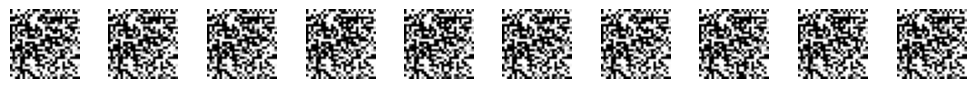

In [27]:
# üretilen görüntüleri görselleştirme
def plot_generate_images(generator,epoch,examples=10,dim=(1,10)):
  noise = np.random.normal(0,1,(examples,z_dim)) # gürültü vektörleri
  gen_images = generator.predict(noise,verbose=0) # generator'un ürettiği görüntüler
  gen_images = 0.5 * gen_images + 0.5 # görüntüyü ölçeklendirme

  plt.figure(figsize=(10,1))
  for i in range(gen_images.shape[0]):
    plt.subplot(dim[0],dim[1],i+1)#alt grafikleri oluşturma
    plt.imshow(gen_images[i,:,:,0],cmap='gray')#görünütyü gri tonlama olarak göster
    plt.axis('off')
  plt.tight_layout()
  plt.show()

plot_generate_images(generator,epochs)